In [ ]:
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

These are physical constants in this problem, which we'll set to 1 for ease:

In [ ]:
# This is a granularity parameter:
delta = 0.0005

In [ ]:
class ExponentialBoundaryCondition(tf.keras.layers.Layer):

    def __init__(self, exp=1.0, trainable=True):
        tf.keras.layers.Layer.__init__(self)
        # This is the parameter controlling the shape of the exponent:
        self.exponent = tf.Variable(exp, trainable=trainable, dtype=tf.float32)


    def call(self, inputs):
        return tf.exp(-(self.exponent * inputs)**2 / 2.)


In [ ]:
class CorrectWavefunction(tf.keras.layers.Layer):


    def __init__(self, n):
        tf.keras.layers.Layer.__init__(self)
        # N is the degree of the polynomial:
        self.n = n
        self.alpha = M * omega / hbar
        self.norm  = np.power(self.alpha / np.pi, 0.25)

        if self.n == 0:
            pass
        elif self.n == 1:
            self.norm *= np.sqrt(2.)
        elif self.n == 2:
            self.norm *= np.sqrt(0.5)
        else:
            raise Exception("Unsupported degree of ", n)

        self.exp = ExponentialBoundaryCondition(exp=np.sqrt(self.alpha), trainable=False)

    def call(self, inputs):

        y = inputs

        boundary_condition = self.exp(y)

        if self.n == 0:
            polynomial = 1
        elif self.n == 1:
            polynomial = y
        elif self.n == 2:
            polynomial = 2 * y**2 - 1

        return self.norm * boundary_condition * polynomial


In [ ]:
class NeuralWavefunction(tf.keras.layers.Layer):

    def __init__(self):
        tf.keras.layers.Layer.__init__(self)
        self.layer1 = tf.keras.layers.Dense(32)
        self.layer2 = tf.keras.layers.Dense(32)
        self.layer3 = tf.keras.layers.Dense(1)
        self.norm   = 1.0

        # This is an exponent for normalization:
        self.exp = ExponentialBoundaryCondition()

    def call(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = tf.nn.tanh(x)
        x = self.layer2(x)
        x = tf.nn.tanh(x)
        x = self.layer3(x)
        boundary_condition = self.exp(inputs)
        output = self.norm*x*boundary_condition
        return output

    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        value = self.call(inputs)
        N = value ** 2
        delta = inputs[1]-inputs[0]
        N = tf.reduce_sum(N) * delta
        self.norm *= 1/tf.sqrt(N)
        # The normalization condition is that the integral of the wavefunction squared
        # should be equal to 1 (probability sums to 1.)
        return



In [ ]:
# This is preparing input data that is differentiable:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

In [ ]:
w_0 = CorrectWavefunction(n=0)
w_1 = CorrectWavefunction(n=1)
w_2 = CorrectWavefunction(n=2)

In [ ]:
y_0 = w_0(x)
y_1 = w_1(x)
y_2 = w_2(x)

In [ ]:
print("N==0 integral: ", tf.reduce_sum(y_0**2) * delta)
print("N==1 integral: ", tf.reduce_sum(y_1**2) * delta)
print("N==2 integral: ", tf.reduce_sum(y_2**2) * delta)

N==0 integral:  tf.Tensor(1.0005498, shape=(), dtype=float32)
N==1 integral:  tf.Tensor(1.0005497, shape=(), dtype=float32)
N==2 integral:  tf.Tensor(1.0005496, shape=(), dtype=float32)


In [ ]:
print("N_0 * N_1 integral: ", tf.reduce_sum(y_0*y_1) * delta)
print("N_0 * N_2 integral: ", tf.reduce_sum(y_0*y_2) * delta)
print("N_1 * N_2 integral: ", tf.reduce_sum(y_1*y_2) * delta)

N_0 * N_1 integral:  tf.Tensor(0.0, shape=(), dtype=float32)
N_0 * N_2 integral:  tf.Tensor(-1.4305115e-09, shape=(), dtype=float32)
N_1 * N_2 integral:  tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
w_nn      = NeuralWavefunction()
y_nn      = w_nn(x)
print("Neural Network function normalization: ", tf.reduce_sum(y_nn**2)*delta)

Neural Network function normalization:  tf.Tensor(0.029502202, shape=(), dtype=float32)


In [ ]:
w_nn.update_normalization(x)
y_nn      = w_nn(x)
print("Neural Network function normalization: ", tf.reduce_sum(y_nn**2)*delta)

Neural Network function normalization:  tf.Tensor(1.0005496, shape=(), dtype=float32)


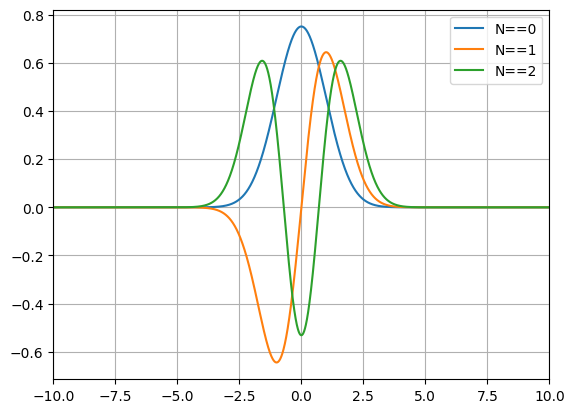

In [ ]:
plt.plot(x.numpy(), y_0.numpy(), label="N==0")
plt.plot(x.numpy(), y_1.numpy(), label="N==1")
plt.plot(x.numpy(), y_2.numpy(), label="N==2")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

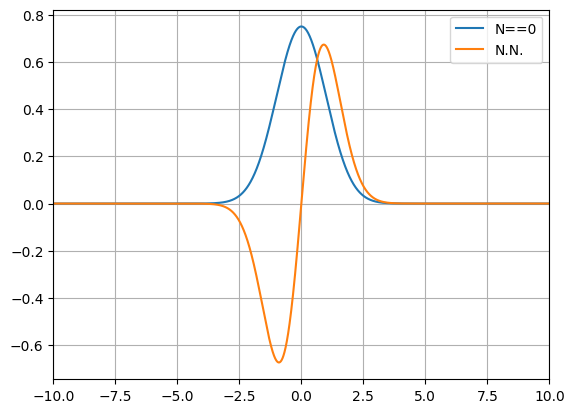

In [ ]:
plt.plot(x.numpy(), y_0.numpy(), label="N==0")
plt.plot(x.numpy(), y_nn.numpy(), label="N.N.")
''
plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

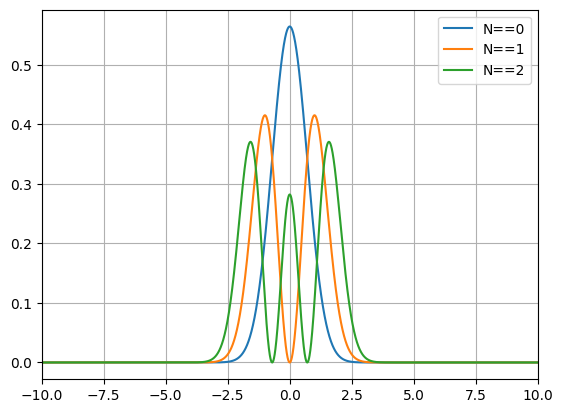

In [ ]:
plt.plot(x.numpy(), (y_0**2).numpy(), label="N==0")
plt.plot(x.numpy(), (y_1**2).numpy(), label="N==1")
plt.plot(x.numpy(), (y_2**2).numpy(), label="N==2")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

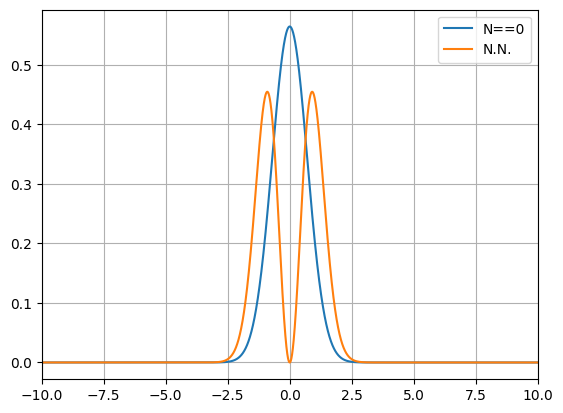

In [ ]:
plt.plot(x.numpy(), (y_0**2).numpy(), label="N==0")
plt.plot(x.numpy(), (y_nn**2).numpy(), label="N.N.")

plt.xlim([-10,10])

plt.legend()

plt.grid(True)
plt.show()

Hamiltonian

In [ ]:
def potential_energy(wavefunction, inputs, delta):
    k1 = 0.5
    k2 = 0.0
    temp = k1 * wavefunction(inputs)**2 * inputs**2 + k2*wavefunction(inputs)**4 * inputs**4
    return tf.reduce_sum(temp) * delta

In [ ]:
print("PE of w_0: ", potential_energy(w_0, x, delta))
print("PE of w_1: ", potential_energy(w_1, x, delta))
print("PE of w_2: ", potential_energy(w_2, x, delta))
print("PE of w_nn: ", potential_energy(w_nn, x, delta))

PE of w_0:  tf.Tensor(0.25013742, shape=(), dtype=float32)
PE of w_1:  tf.Tensor(0.7504122, shape=(), dtype=float32)
PE of w_2:  tf.Tensor(1.2506871, shape=(), dtype=float32)
PE of w_nn:  tf.Tensor(0.6234595, shape=(), dtype=float32)


In [ ]:
def kinetic_energy(wavefunction, inputs, delta):
    tape = tf.GradientTape()
    with tape:
        y = wavefunction(inputs)
    wavefunction_prime = tape.gradient(y, inputs)
    return tf.reduce_sum(wavefunction_prime**2) * delta

In [ ]:
print("KE of w_0: ", kinetic_energy(w_0, x, delta))
print("KE of w_1: ", kinetic_energy(w_1, x, delta))
print("KE of w_2: ", kinetic_energy(w_2, x, delta))
print("KE of w_nn: ", kinetic_energy(w_nn, x, delta))

KE of w_0:  tf.Tensor(0.50027484, shape=(), dtype=float32)
KE of w_1:  tf.Tensor(1.5008246, shape=(), dtype=float32)
KE of w_2:  tf.Tensor(2.5013742, shape=(), dtype=float32)
KE of w_nn:  tf.Tensor(1.8067777, shape=(), dtype=float32)


In [ ]:
def normalization(wavefunction, inputs, delta):
    psi = wavefunction(inputs)**2
    return tf.reduce_sum(psi*delta)

In [ ]:
def energy_calculation(wavefunction, inputs, delta):
    norm = normalization(wavefunction, inputs, delta)
    pe = potential_energy(wavefunction, inputs, delta)
    ke = kinetic_energy(wavefunction, inputs, delta)
    energy = (1/norm) * ( pe +  ke)
    return energy

In [ ]:
print("Energy of w_0: ", energy_calculation(w_0, x, delta))
print("Energy of w_1: ", energy_calculation(w_1, x, delta))
print("Energy of w_2: ", energy_calculation(w_2, x, delta))
print("Energy of w_nn: ", energy_calculation(w_nn, x, delta))

Energy of w_0:  tf.Tensor(0.7499999, shape=(), dtype=float32)
Energy of w_1:  tf.Tensor(2.2500002, shape=(), dtype=float32)
Energy of w_2:  tf.Tensor(3.75, shape=(), dtype=float32)
Energy of w_nn:  tf.Tensor(2.4289024, shape=(), dtype=float32)


In [ ]:
def energy_computation(wavefunction, inputs, delta):
    # This function takes the inputs (assumed to be a range of real value parameters)
    # And computes the expectation value of the energy.
    # create a gradient tape:
    tape = tf.GradientTape()
    # This is the value of the wave function:
    with tape:
        w_of_x = wavefunction(inputs)

    # This is the first derivative of the wave function:
    w_prime_dx = tape.gradient(w_of_x, inputs)

    # Now we can compute integrals:
    normalization = tf.reduce_sum(w_of_x**2) * delta
    pe = w_of_x**2 * inputs**2
    ke = w_prime_dx**2
    ke = tf.reduce_sum(ke) * delta
    pe = tf.reduce_sum(pe) * delta
    energy = (pe + ke) / normalization

    return energy

In [ ]:
def generate_input(delta):
    # Create fresh input data:
    _x = np.arange(-10, 10, delta, dtype=np.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = tf.Variable(_x, trainable = True)

    return x

def training_step(wavefunction, optimizer, delta):
    # Clear all gradients from the optimizer:
    exterior_tape = tf.GradientTape()
    x = generate_input(delta)
    wavefunction.update_normalization(x)

    # Compute the energy:
    with exterior_tape:
        energy = energy_computation(wavefunction, x, delta)

    # We back-prop'd through the wave function once already in the energy computation.  Clear the gradients:
    gradients = exterior_tape.gradient(energy, wavefunction.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wavefunction.trainable_variables))
    # Lastly, update the normaliztion
    wavefunction.update_normalization(x)
    return  energy



In [ ]:
w_nn = NeuralWavefunction()
delta = 0.0001

x = generate_input(delta)
y = w_nn(x)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

energy_history = []
step_history = []

for i in range(500):
    start = time.time()
    energy = training_step(w_nn, optimizer, delta)
    end = time.time()
    if i % 10 == 0: print(f"Energy :{energy.numpy()}, {end - start:.2}s per step")


    energy_history.append(energy.numpy())
    step_history.append(i)

Energy :3.007321357727051, 0.46s per step
Energy :1.4159679412841797, 0.35s per step
Energy :1.057784080505371, 0.34s per step
Energy :1.050454020500183, 0.33s per step
Energy :1.0102519989013672, 0.33s per step
Energy :1.007867693901062, 0.52s per step
Energy :1.0069963932037354, 0.34s per step
Energy :1.0046570301055908, 0.34s per step
Energy :1.0040429830551147, 0.32s per step
Energy :1.0035638809204102, 0.34s per step
Energy :1.0030913352966309, 0.35s per step
Energy :1.0027358531951904, 0.38s per step
Energy :1.002455234527588, 0.32s per step
Energy :1.002218246459961, 0.35s per step
Energy :1.0020146369934082, 0.35s per step
Energy :1.001837968826294, 0.34s per step
Energy :1.0016818046569824, 0.34s per step
Energy :1.0015417337417603, 0.36s per step
Energy :1.0014145374298096, 0.41s per step
Energy :1.0012983083724976, 0.34s per step
Energy :1.00119149684906, 0.35s per step
Energy :1.0010935068130493, 0.44s per step
Energy :1.0010027885437012, 0.34s per step
Energy :1.0009189844

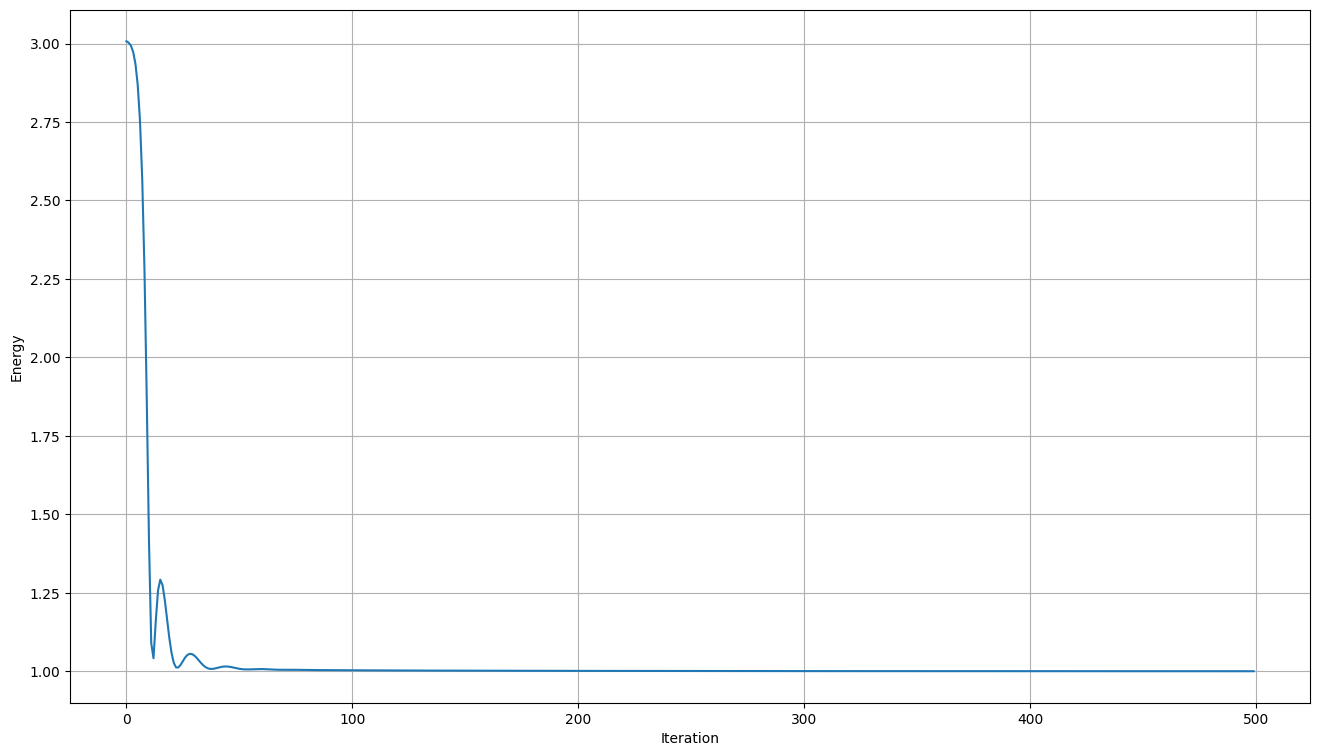

In [ ]:
fig = plt.figure(figsize=(16,9))

plt.plot(step_history, energy_history)
plt.grid(True)
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.show()


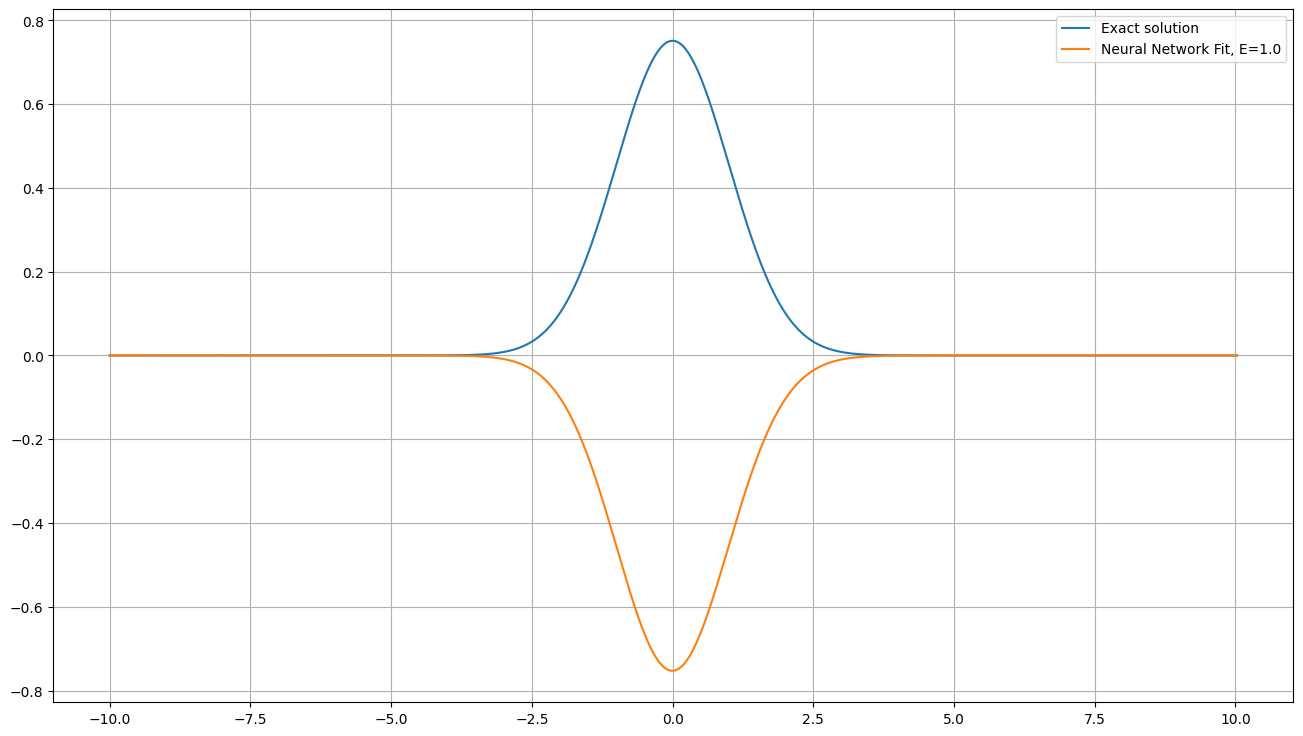

In [ ]:
# Create fresh input data:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x)

y_exact = w_0(x)
y_fit   = w_nn(x)

x_numpy = x.numpy()

fig = plt.figure(figsize=(16,9))

plt.plot(x_numpy, y_exact.numpy(), label="Exact solution")
plt.plot(x_numpy, -y_fit.numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

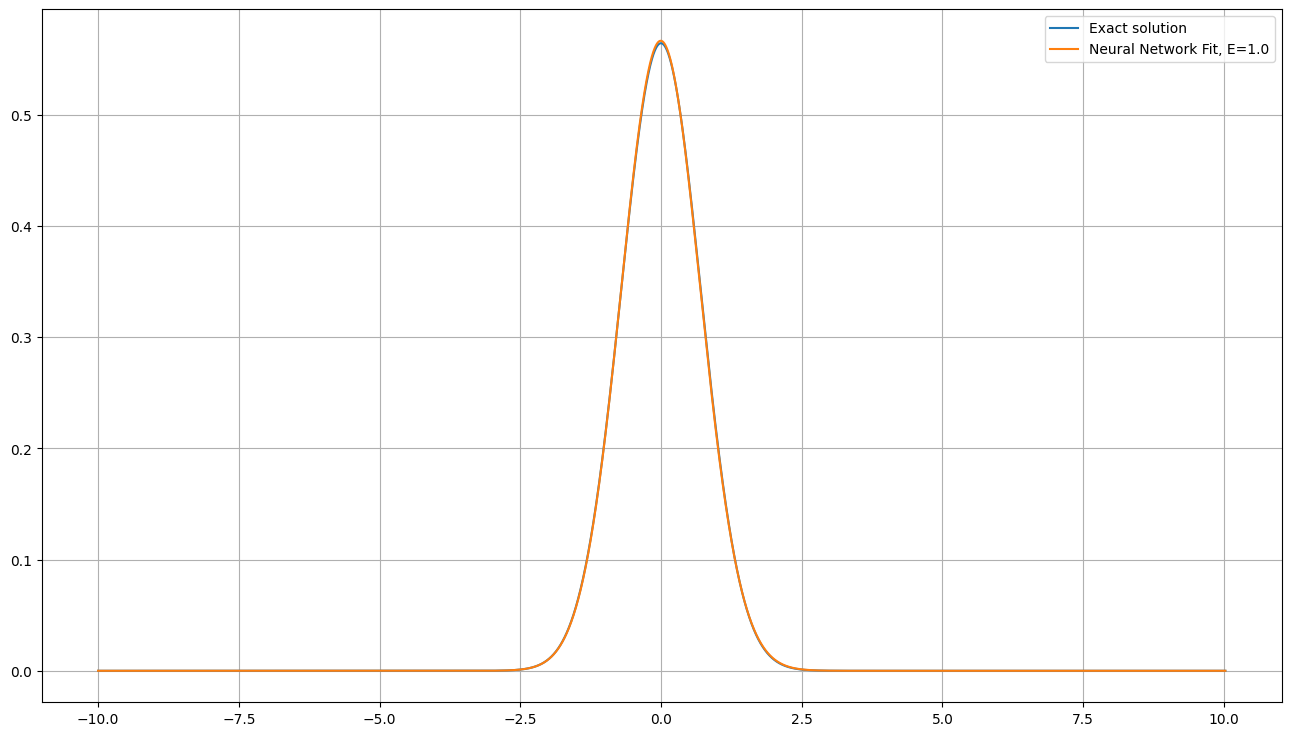

In [ ]:

# Create fresh input data:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

p_exact = w_0(x)**2
p_fit   = w_nn(x)**2

x_numpy = x.numpy()

fig = plt.figure(figsize=(16,9))

plt.plot(x_numpy, p_exact.numpy(), label="Exact solution")
plt.plot(x_numpy, p_fit.numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()

Higher states

In [ ]:
def training_step_excited_state(wavefunction, known_wavefunction, optimizer, delta, alpha=50):

    x = generate_input(delta)

    # Compute the energy:
    tape = tf.GradientTape()

    with tape:
        energy = energy_computation(wavefunction, x, delta)

    # Now, we have the energy.  We should make sure it is orthogonal to the known wavefunction:
    y0 = known_wavefunction(x)
    with tape:
        y1 = wavefunction(x)
        ortho = (tf.reduce_sum(y0 * y1) * delta)**2

        # We scale here the orthogonality condition.  Note that it's a really high scaling compared to the energy.
        # We need the orthogonality to be very good to have any hope of converging!

        # At home: Try with a lower constraint.  Does it still work?
        energy += alpha*ortho


    gradients = tape.gradient(energy, wavefunction.trainable_variables)

    optimizer.apply_gradients(zip(gradients, wavefunction.trainable_variables))


    return  energy - alpha*ortho, ortho




In [ ]:
w_nn_excited = NeuralWavefunction()
delta = 0.0001

optimizer = tf.keras.optimizers.Adam()

energy_history = []
ortho_history = []
step_history = []

for i in range(100):
    energy, ortho = training_step_excited_state(w_nn_excited, w_nn, optimizer, delta, alpha=500)
    if i % 10 == 0:
        print(f"Step {i}, E =={energy}, Orthogonality={ortho}")

    energy_history.append(energy.numpy())
    ortho_history.append(ortho.numpy())
    step_history.append(i)





Step 0, E ==5.663022041320801, Orthogonality=3.289914729531773e-10
Step 10, E ==3.02544903755188, Orthogonality=8.880150562617928e-05
Step 20, E ==3.0196521282196045, Orthogonality=3.0049584893276915e-05
Step 30, E ==3.0148491859436035, Orthogonality=1.0908536751230713e-05
Step 40, E ==3.010997772216797, Orthogonality=3.036450607396546e-06
Step 50, E ==3.0079503059387207, Orthogonality=7.332644003099631e-08
Step 60, E ==3.0055906772613525, Orthogonality=3.831688388800103e-07
Step 70, E ==3.003864288330078, Orthogonality=6.768762261799566e-08
Step 80, E ==3.002638339996338, Orthogonality=6.813297659391537e-08
Step 90, E ==3.0018064975738525, Orthogonality=2.7105546696049032e-09


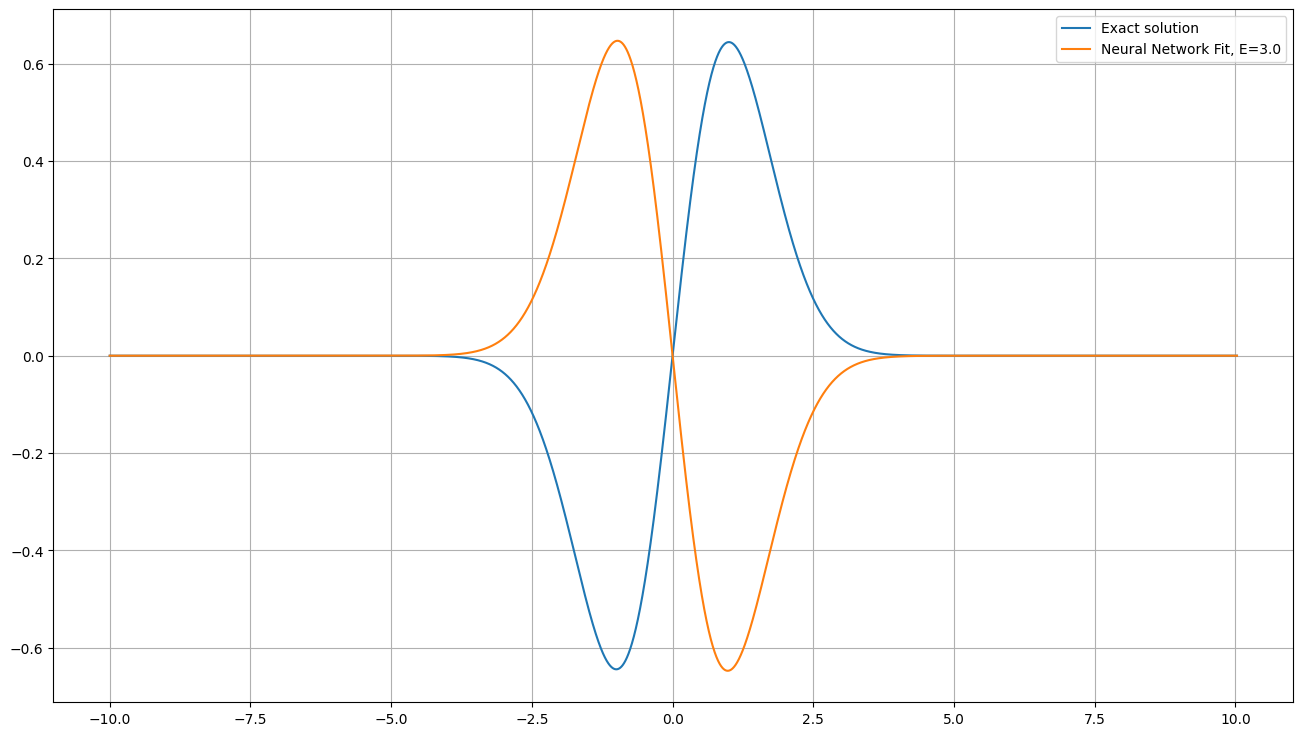

In [ ]:

# Create fresh input data:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

# Make sure the normalization is updated:
w_nn_excited.update_normalization(x)

y_exact = w_1(x)
y_fit   = w_nn_excited(x)

x_numpy = x.numpy()

fig = plt.figure(figsize=(16,9))

plt.plot(x_numpy, y_exact.numpy(), label="Exact solution")
plt.plot(x_numpy, y_fit.numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()


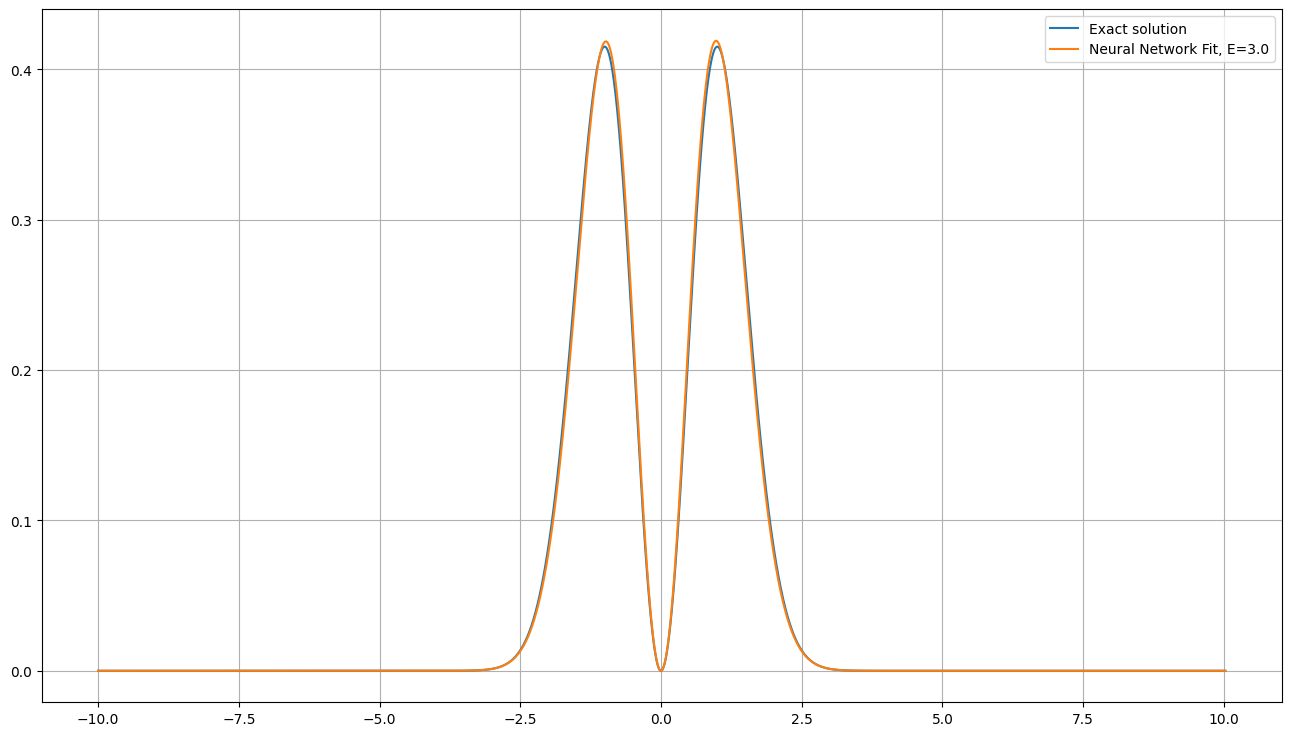

In [ ]:
# Create fresh input data:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

p_exact = w_1(x)**2
p_fit   = w_nn_excited(x)**2

x_numpy = x.numpy()

fig = plt.figure(figsize=(16,9))

plt.plot(x_numpy, p_exact.numpy(), label="Exact solution")
plt.plot(x_numpy, p_fit.numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()
